<a href="https://colab.research.google.com/github/akashapare/bosch-classification/blob/main/mobile_netV2_RMSprop_layers_first%20run_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#imports and declerations

In [10]:
from __future__ import print_function
import tensorflow as tf
from tensorflow import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image,ImageFilter,ImageStat,ImageTransform, ImageOps,ImageShow
import random
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy, categorical_crossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam,Adagrad,RMSprop
from tensorflow.keras.applications import MobileNetV2
#start = dt.datetime.now()

In [7]:
import zipfile
import os

zip_ref = zipfile.ZipFile('/content/drive/MyDrive/dataset.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/content') #Extracts the files into the /tmp folder
zip_ref.close()


In [6]:
INPUT_DIR = '/content/dataset'
#INPUT_DIR = '/content/drive/MyDrive/edge dataset'
#INPUT_DIR = '/content/drive/MyDrive/gray dataset'
#INPUT_DIR = '/content/drive/MyDrive/gray_eq dataset'

In [8]:
BASE_SIZE =224 
NCATS = 5
tf.random.set_seed(1996)

In [9]:
EPOCHS = 15
size = 224
batchsize = 50

#model for colour images

NOTE:
this model is trained on top of previous weight improvement with 0.86 accuracy


In [11]:
model = MobileNetV2(input_shape=(size, size, 3), alpha=1., weights=None, classes=NCATS)
'''
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy',
              metrics=['accuracy',keras.metrics.Precision(),keras.metrics.Recall(),keras.metrics.AUC()])
'''
model.compile(optimizer=RMSprop(lr=0.001), loss='categorical_crossentropy',
              metrics=['accuracy',keras.metrics.Precision(),keras.metrics.Recall(),keras.metrics.AUC()])
print(model.summary())

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [12]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',validation_split=0.3,)
validation_generator=datagen.flow_from_directory(INPUT_DIR,
                            target_size=(size,size),
                            color_mode='rgb',
                            class_mode='categorical',
                            batch_size=batchsize,
                            seed=1996,
                            subset='validation')
train_generator=datagen.flow_from_directory(INPUT_DIR,
                            target_size=(size,size),
                            color_mode='rgb',
                            class_mode='categorical',
                            batch_size=batchsize,
                            seed=1996,
                            subset='training')

Found 1026 images belonging to 5 classes.
Found 2403 images belonging to 5 classes.


In [13]:
from sklearn.utils import class_weight 
class_weights = class_weight.compute_class_weight(
           'balanced',
            np.unique(train_generator.classes), 
            train_generator.classes)
class_weights= dict(enumerate(class_weights))
checkpoint_filepath="weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1,
    save_weights_only=True)
history=model.fit_generator(train_generator,
    steps_per_epoch = train_generator.samples // batchsize,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batchsize,
    epochs = EPOCHS,
    class_weight=class_weights,callbacks=[model_checkpoint_callback],workers=4)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/15
48/48 [==============================] - 104s 1s/step - loss: 1.4691 - accuracy: 0.3332 - precision: 0.3456 - recall: 0.1632 - auc: 0.6998 - val_loss: 1.5877 - val_accuracy: 0.6140 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7340

Epoch 00001: val_accuracy improved from -inf to 0.61400, saving model to weights-improvement-01-0.61.hdf5
Epoch 2/15
48/48 [==============================] - 72s 1s/step - loss: 0.9417 - accuracy: 0.5142 - precision: 0.5735 - recall: 0.3366 - auc: 0.8295 - val_loss: 1.5327 - val_accuracy: 0.6140 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7657

Epoch 00002: val_accuracy did not improve from 0.61400
Epoch 3/15
48/48 [==============================] - 70s 1s/step - loss: 0.7296 - accuracy: 0.6239 - precision: 0.6594 - recall: 0.5108 - auc: 0.8789 - val_loss: 1.3813 - val_

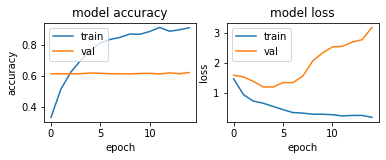

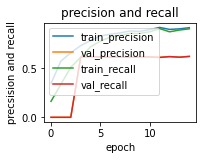

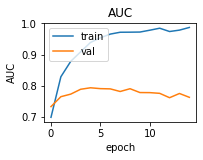

In [15]:
plt.subplot(221)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'val'], loc='upper left')  
  
# summarize history for loss  
  
plt.subplot(222)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'val'], loc='upper left')  
plt.show()  
# precision and recall
plt.subplot(223)  
plt.plot(history.history['precision'],'-')  
plt.plot(history.history['val_precision'],'-') 
plt.plot(history.history['recall'],'-')  
plt.plot(history.history['val_recall'],'-')  
plt.title('precision and recall')  
plt.ylabel('precsision and recall')  
plt.xlabel('epoch')  
plt.legend(['train_precision', 'val_precision','train_recall','val_recall'], loc='upper left')  
plt.show()  

#AUC
  
plt.subplot(224)  
plt.plot(history.history['auc'])  
plt.plot(history.history['val_auc'])  
plt.title('AUC')  
plt.ylabel('AUC')  
plt.xlabel('epoch')  
plt.legend(['train', 'val'], loc='upper left')  
plt.show()  

In [24]:
print(history.history.keys())
print(history.history.values())
#np.save('history_mobilenetV2_RMSprop_lr_0.002.npy',history.history)

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'auc', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_auc'])
dict_values([[1.4691351652145386, 0.9416547417640686, 0.7295751571655273, 0.6581568717956543, 0.5525634288787842, 0.4457220733165741, 0.3494893014431, 0.33081871271133423, 0.2948378324508667, 0.2936429977416992, 0.2789728045463562, 0.2364637404680252, 0.2549809217453003, 0.2543286681175232, 0.19202224910259247], [0.3331916630268097, 0.5142371654510498, 0.623884379863739, 0.6999574899673462, 0.7637059092521667, 0.8125796914100647, 0.835529088973999, 0.8487038016319275, 0.8703782558441162, 0.8682532906532288, 0.886952817440033, 0.9124521613121033, 0.88780277967453, 0.8975775837898254, 0.9107522368431091], [0.3456345498561859, 0.573497474193573, 0.659352719783783, 0.7318435907363892, 0.7837963104248047, 0.8303085565567017, 0.8491644859313965, 0.8618277311325073, 0.8819414377212524, 0.8784313797950745, 0.8962510824203491, 0.917778730392456, 0.8981643319129944,

trial

In [20]:
model_try=model.load_weights('/content/drive/MyDrive/color model mobilenetv2 RMSprop/weights-improvement-15-0.62.hdf5')

In [21]:
input=('/content/dataset/default/080721img41985.jpg')

img = image.load_img(input, target_size=(224, 224))
input = image.img_to_array(img)                           
input = input.reshape((1,) + input.shape)                   
input /= 255.0
np.argmax(model.predict(input))

3

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide


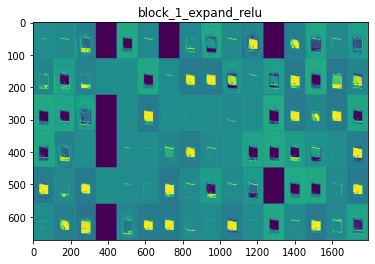

In [25]:
from keras.models import Model

layer_outputs = [layer.output for layer in model.layers[:12]] # Extracts the outputs of the top 12 layers
activation_model = Model(inputs=model.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input

activations = activation_model.predict(input) # Returns a list of five Numpy arrays: one array per layer activation


layer_names = []
for layer in model.layers[:12]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')